In [6]:
# Load brain data

# Access nifti, bval & bvec files
from os.path import expanduser, join
home = expanduser('~')
dname = join(home, 'brain-data-neil')

fdwi = join(dname, 'cdmri11_r.nii')
fbval = join(dname, 'parameters_new_bval.txt')
fbvec = join(dname, 'parameters_new_bvec.txt')

# Load dMRI datasets 
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)

# Check size of data --> (77, 92, 56, 1344)
print(data.shape)

# print(type(data)) # numpy.memmap
# print(data) # bunch of zeros
# print(affine) # x,y,z coordinates
# print(img) # info about image, e.g. datatype float32 


(77, 92, 56, 1344)


In [7]:
## Load bvals & bvecs
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

## Create object gradient_table to hold bvals & bvecs
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)
print(gtab.bvals)
print(gtab.bvecs)

[3000. 3000. 3000. ... 2000. 2000. 2000.]
[[-0.52602 -0.71803 -0.45578]
 [-0.52602 -0.71803 -0.45578]
 [-0.52602 -0.71803 -0.45578]
 ...
 [ 0.49906 -0.68361  0.53255]
 [ 0.49906 -0.68361  0.53255]
 [ 0.49906 -0.68361  0.53255]]


In [8]:
# Set up acquisition scheme using bval, bvec

# Import relevant modules
from dmipy.core import modeling_framework
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from os.path import join
import numpy as np

# Load parameters and convert to SI units
bvalues = np.loadtxt(join('parameters_new_bval.txt'))  # given in s/m^2
bvalues_SI = bvalues * 1e6 # now given in SI units as s/mm^2
gradient_directions = np.loadtxt(join('parameters_new_bvec.txt'))

# delta and Delta times in seconds
delta = 0.0242
Delta = 0.0391

# Acquisition scheme
acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta)
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1344
number of b0 measurements: 84
number of DWI shells: 4

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |84        |0               |0                        |24.2       |39.1      |N/A  
1           |84        |500             |19                       |24.2       |39.1      |N/A  
2           |252       |1000            |27                       |24.2       |39.1      |N/A  
3           |420       |2000            |39                       |24.2       |39.1      |N/A  
4           |504       |3000            |48                       |24.2       |39.1      |N/A  


In [11]:
# Create ball & stick model, then fit 1 voxel to this model

# Import relevant modules
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

# Create ball and stick model
stick = cylinder_models.C1Stick()
ball = gaussian_models.G1Ball()
ball_and_stick = MultiCompartmentModel(models=[ball, stick])

# Display parameters for model
print(ball_and_stick.parameter_cardinality)

# Define 1 voxel and store in variable E
x_pos = 31
y_pos = 40
z_pos = 34
E = data[x_pos,y_pos,z_pos,:]
# print(E.shape)

# Fit this voxel to the model
fitted_ball_and_stick = ball_and_stick.fit(acq_scheme, E)


OrderedDict([('G1Ball_1_lambda_iso', 1), ('C1Stick_1_mu', 2), ('C1Stick_1_lambda_par', 1), ('partial_volume_0', 1), ('partial_volume_1', 1)])
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.39186620712280273 seconds
Fitting of 1 voxels complete in 0.06943798065185547 seconds.
Average of 0.06943798065185547 seconds per voxel.


In [12]:
# Optimised results
fitted_ball_and_stick.fitted_parameters

{'G1Ball_1_lambda_iso': array([1.08696065e-09]),
 'C1Stick_1_mu': array([[2.80149062, 1.93197056]]),
 'C1Stick_1_lambda_par': array([3.52601283e-10]),
 'partial_volume_0': array([0.66517359]),
 'partial_volume_1': array([0.33482641])}

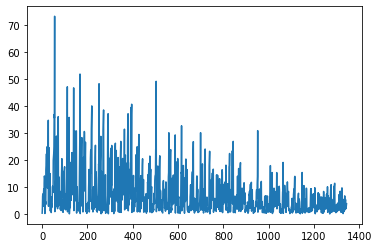

In [6]:
# Plot change in signal intensities for 1 voxel
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(E)

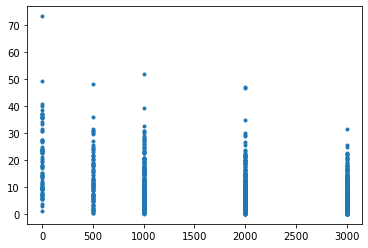

In [7]:
fig, ax = plt.subplots()
ax.plot(bvalues, E, '.')

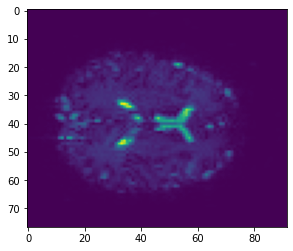

In [8]:
# Show 1 slice of diffusion MRI
plt.imshow(data[:,:,30,500])

In [9]:
# Fit ALL voxels of brain data to ball & stick model

import numpy as np
# use data.shape[0:2] and put into array
# have array for each parameter, e.g. mu

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        # if mask[x,y,30] == 1
        E = data[x,y,30,:]
        fitted_ball_and_stick = ball_and_stick.fit(acq_scheme, E) # in middle of loop
        # extract parameter
        # put into array, e.g. mu[x,y,30] = parameter
        

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 0.5468590259552002 seconds
Fitting of 0 voxels complete in 0.012157201766967773 seconds.
Average of inf seconds per voxel.


/Applications/anaconda3/lib/python3.8/site-packages/dmipy/core/modeling_framework.py:1212: RuntimeWarning: divide by zero encountered in true_divide
  fitting_time / N_voxels))


ValueError: operands could not be broadcast together with shapes (0,) (6,) 